In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import yfinance as yf
import requests
from bs4 import BeautifulSoup
import matplotlib.dates as mdates
from IPython.display import display
import numpy as np
import seaborn as sns

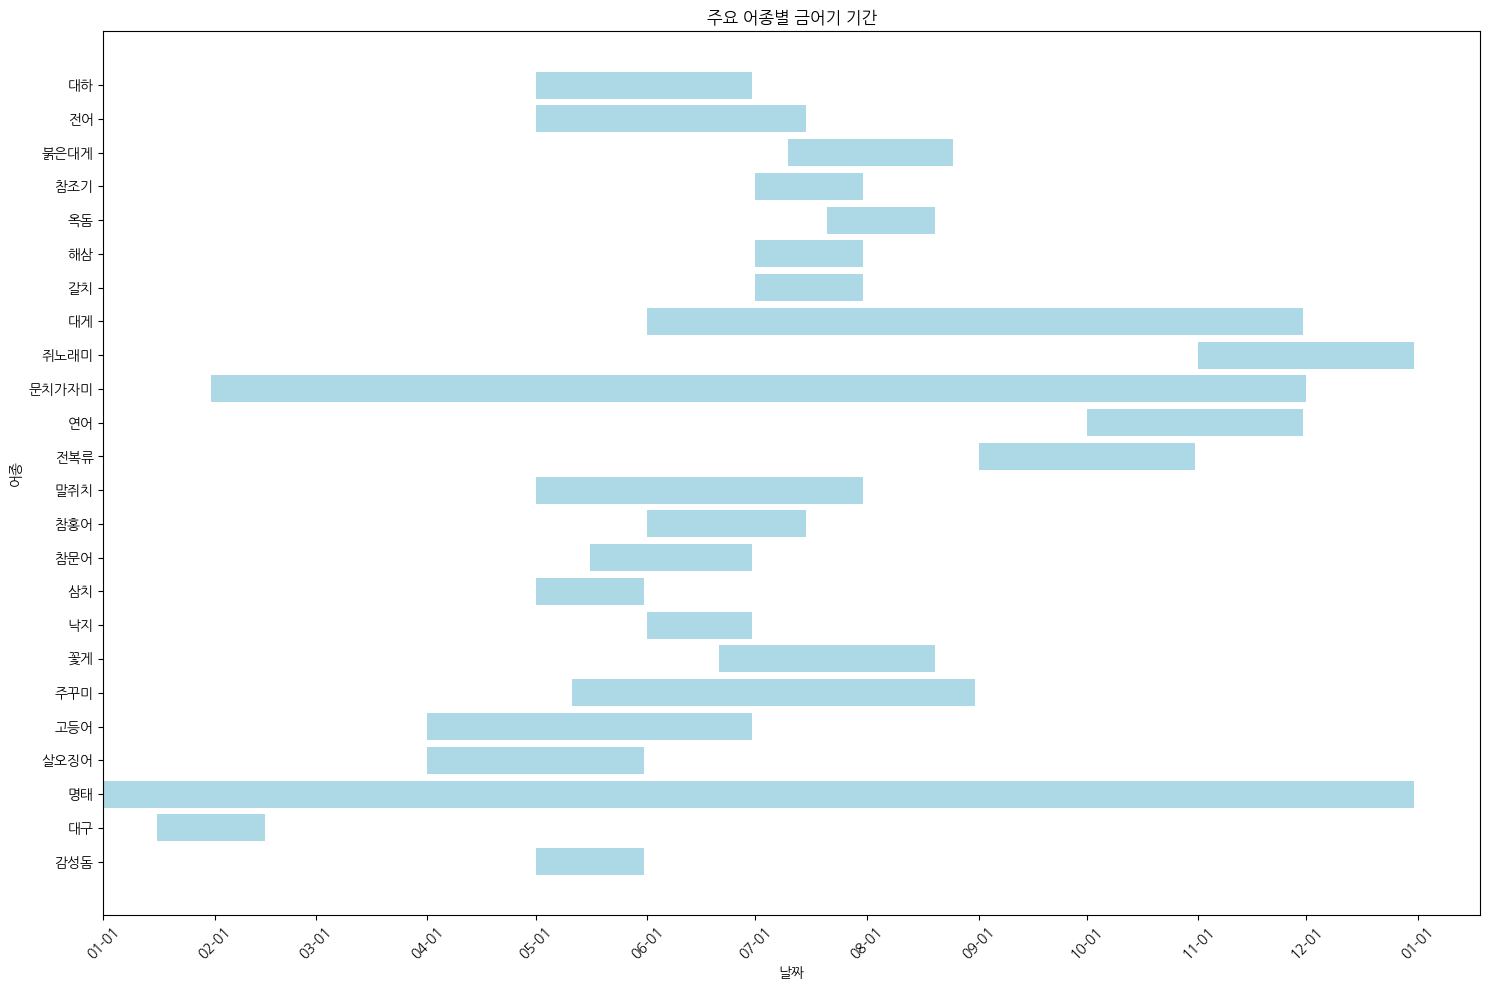

In [5]:


# 데이터 경로 설정
forecast_file_path = "../data/processed/forecast_merged2.csv"
price_file_path = "../data/raw/ikh_item_price_2025-01-15.csv"

# 데이터 불러오기
forecast_df = pd.read_csv(forecast_file_path)
price_df = pd.read_csv(price_file_path)

# 1. 날짜 형식 변환
forecast_df['일시'] = pd.to_datetime(forecast_df['일시'], errors='coerce')
price_df['priceDate'] = pd.to_datetime(price_df['priceDate'], errors='coerce')

# 2. 날짜 기준으로 두 데이터 병합
merged_df = pd.merge(price_df, forecast_df, left_on='priceDate', right_on='일시', how='inner')

# 3. 금어기 데이터 추가 - 가상 금어기 정보
goldfish_season = {
    '농어': ('2022-05-01', '2022-06-30'),
    '광어': ('2022-04-01', '2022-05-31'),
    '대게': ('2022-07-01', '2022-08-31'),
    '연어': ('2022-09-01', '2022-10-31'),
    '우럭': ('2022-06-01', '2022-07-31'),
    '참돔': ('2022-03-01', '2022-04-30'),
    '방어': ('2022-11-01', '2022-12-31')
}

# 금어기 컬럼 추가
for item, (start, end) in goldfish_season.items():
    merged_df.loc[(merged_df['item'] == item) & (merged_df['priceDate'] >= pd.to_datetime(start)) &
                  (merged_df['priceDate'] <= pd.to_datetime(end)), '금어기'] = True
merged_df['금어기'].fillna(False, inplace=True)

# 4. 결측치 처리
numeric_columns = merged_df.select_dtypes(include=['float64', 'int64']).columns
merged_df[numeric_columns] = merged_df[numeric_columns].apply(pd.to_numeric, errors='coerce')
merged_df.fillna(0, inplace=True)

# ✅ 데이터프레임 출력 함수 (로컬 환경용)
def display_dataframe_to_user(name, dataframe):
    print(f"📊 {name}")
    display(dataframe)

# 데이터프레임 확인
display_dataframe_to_user(name="Merged Fish Price and Weather Data", dataframe=merged_df)

C:\Users\user\AppData\Local\Temp\ipykernel_114492\2053734358.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['금어기'].fillna(False, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_114492\2053734358.py:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df['금어기'].fillna(False, inplace=

📊 Merged Fish Price and Weather Data


,priceDate,minPrice,avgPrice,maxPrice,item,market,지점,일시,풍속(m/s),풍향(deg),...,현지기압(hPa),습도(%),기온(°C),수온(°C),최대파고(m),유의파고(m),평균파고(m),파주기(sec),파향(deg),금어기
0,2020-01-01,25000,28130,30000,농어,노량진 1층,22105,2020-01-01,6.4,284.0,...,1027.5,48.0,3.2,14.8,3.5,2.0,1.4,8.0,41.0,False
1,2020-01-01,25000,28130,30000,농어,노량진 1층,22107,2020-01-01,11.0,354.0,...,1032.2,70.0,5.1,17.6,3.2,2.0,1.4,8.0,357.0,False
2,2020-01-01,25000,28130,30000,농어,노량진 1층,22186,2020-01-01,6.0,326.0,...,1034.2,56.0,1.7,11.1,2.8,1.6,1.2,6.4,333.0,False
3,2020-01-01,25000,28130,30000,농어,노량진 1층,22188,2020-01-01,5.2,348.0,...,1030.7,42.0,2.3,11.6,1.5,0.8,0.6,3.4,298.0,False
4,2020-01-01,25000,28130,30000,농어,노량진 1층,22189,2020-01-01,7.6,317.0,...,0.0,47.0,3.8,17.5,4.4,3.0,2.1,10.7,36.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713206,2020-12-25,30000,30000,30000,방어,부산민락어민활어직판장,22186,2020-12-25,10.7,323.0,...,1024.5,53.0,6.3,11.2,3.0,2.2,1.5,6.4,316.0,False
713207,2020-12-25,30000,30000,30000,방어,부산민락어민활어직판장,22188,2020-12-25,12.1,322.0,...,1018.8,52.0,6.3,13.0,2.1,1.5,1.0,4.6,297.0,False
713208,2020-12-25,30000,30000,30000,방어,부산민락어민활어직판장,22189,2020-12-25,8.9,338.0,...,1017.0,52.0,7.2,17.5,2.2,1.4,1.0,4.3,345.0,False
713209,2020-12-25,30000,30000,30000,방어,부산민락어민활어직판장,22190,2020-12-25,9.2,287.0,...,1016.5,47.0,7.6,14.4,3.3,1.9,1.4,6.4,359.0,False


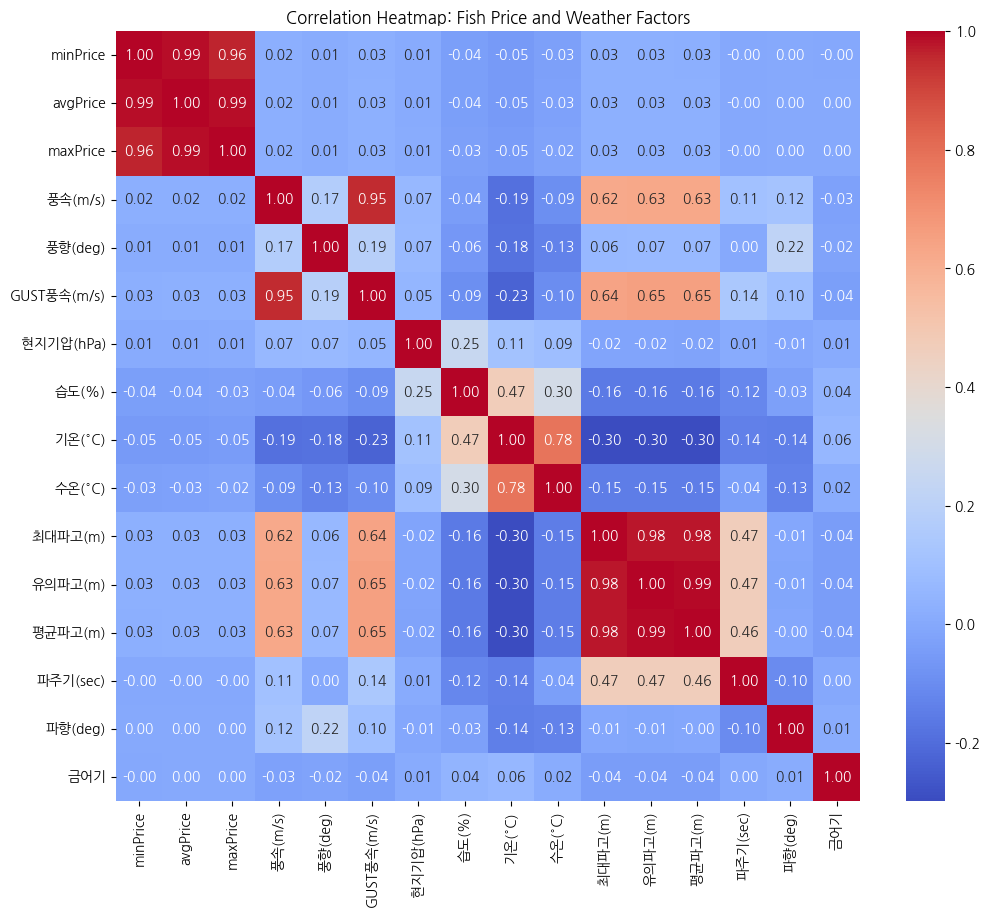

In [13]:
# 생선 가격 관련 컬럼과 기상 요인 관련 컬럼 선택
price_columns = ["minPrice", "avgPrice", "maxPrice"]
weather_columns = [
    "풍속(m/s)", "풍향(deg)", "GUST풍속(m/s)", "현지기압(hPa)", "습도(%)",
    "기온(°C)", "수온(°C)", "최대파고(m)", "유의파고(m)", "평균파고(m)", "파주기(sec)", "파향(deg)", "금어기"
]

# 가격과 기상 요인 데이터 추출
correlation_data = merged_df[price_columns + weather_columns]

# 상관계수 계산
correlation_matrix = correlation_data.corr()

# 상관계수 히트맵 그리기
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap: Fish Price and Weather Factors")
plt.show()

In [10]:
# 어종별로 생선 가격과 기상 요인 간 상관계수를 계산
correlation_results = {}

# 분석할 생선 종류 리스트
fish_types = merged_df['item'].unique()

# 각 어종별로 상관계수를 계산하여 딕셔너리에 저장
for fish in fish_types:
    fish_data = merged_df[merged_df['item'] == fish]
    correlation_matrix = fish_data[price_columns + weather_columns].corr()
    correlation_results[fish] = correlation_matrix["avgPrice"].loc[weather_columns]

# 결과를 데이터프레임으로 변환
correlation_df = pd.DataFrame(correlation_results).T

# 데이터프레임 확인
display_dataframe_to_user(name="Correlation by Fish Type", dataframe=correlation_df)

📊 Correlation by Fish Type


,풍속(m/s),풍향(deg),GUST풍속(m/s),현지기압(hPa),습도(%),기온(°C),수온(°C),최대파고(m),유의파고(m),평균파고(m),파주기(sec),파향(deg)
농어,0.037481,0.017913,0.040050,0.036045,0.004118,-0.021680,0.025974,0.014650,0.022020,0.009637,-0.075158,-0.008953
광어,0.023632,0.007174,0.025431,0.024290,0.028623,0.014590,0.070450,0.001960,0.011012,-0.002730,-0.083397,-0.011282
대게,0.144637,0.082385,0.177408,0.029723,-0.315602,-0.398638,-0.263285,0.202127,0.204198,0.201289,0.099101,0.038288
연어,-0.008689,-0.010294,-0.018315,0.030881,0.142146,0.078787,0.103561,-0.042275,-0.030012,-0.048221,-0.160331,-0.036758
우럭,0.028228,0.020394,0.035810,0.008601,-0.058518,-0.053504,-0.031024,0.036997,0.037909,0.038644,0.026810,0.016173
참돔,0.017075,0.009247,0.017303,0.022239,0.030738,-0.003389,0.035169,0.003428,0.010616,0.000017,-0.078471,-0.017102
방어,0.055247,0.055801,0.065692,-0.023984,0.088330,-0.011763,0.065647,0.027300,0.036779,0.021117,-0.084142,0.010828


In [12]:
# 금어기 여부에 따라 상관계수 계산
goldfish_correlation_results = {}
non_goldfish_correlation_results = {}

# 각 어종별로 금어기와 비금어기 상관계수를 계산하여 딕셔너리에 저장
for fish in fish_types:
    # 금어기 데이터
    goldfish_data = merged_df[(merged_df['item'] == fish) & (merged_df['금어기'] == True)]
    # 비금어기 데이터
    non_goldfish_data = merged_df[(merged_df['item'] == fish) & (merged_df['금어기'] == False)]
    
    # 금어기 기간 상관계수
    goldfish_correlation = goldfish_data[price_columns + weather_columns].corr()
    goldfish_correlation_results[fish] = goldfish_correlation["avgPrice"].loc[weather_columns]
    
    # 비금어기 기간 상관계수
    non_goldfish_correlation = non_goldfish_data[price_columns + weather_columns].corr()
    non_goldfish_correlation_results[fish] = non_goldfish_correlation["avgPrice"].loc[weather_columns]

# 결과를 데이터프레임으로 변환
goldfish_correlation_df = pd.DataFrame(goldfish_correlation_results).T
non_goldfish_correlation_df = pd.DataFrame(non_goldfish_correlation_results).T

# 결과를 보기 좋게 출력
from IPython.display import display

print("📊 Goldfish Season Correlation by Fish Type")
display(goldfish_correlation_df)

print("\n📊 Non-Goldfish Season Correlation by Fish Type")
display(non_goldfish_correlation_df)

📊 Goldfish Season Correlation by Fish Type


,풍속(m/s),풍향(deg),GUST풍속(m/s),현지기압(hPa),습도(%),기온(°C),수온(°C),최대파고(m),유의파고(m),평균파고(m),파주기(sec),파향(deg)
농어,-0.014692,0.004711,-0.010049,0.004285,-0.003073,-0.027700,-0.019666,-0.022787,-0.023966,-0.023737,-0.011102,0.001157
광어,0.006469,-0.014009,0.007929,0.042042,-0.012847,-0.043477,-0.040437,0.013262,0.013020,0.012459,0.011016,-0.005318
대게,0.114865,0.074807,0.119252,-0.018542,0.091010,0.039870,0.129994,0.059665,0.068505,0.066893,-0.026076,0.000276
연어,-0.009321,0.014895,-0.013722,-0.015368,0.046792,0.094860,0.060519,-0.017727,-0.016246,-0.015429,-0.004675,0.001468
우럭,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
참돔,0.008717,0.003488,0.009531,-0.003250,-0.007977,-0.012257,-0.010196,0.013317,0.012608,0.012688,0.004998,0.002515
방어,-0.170648,0.081749,-0.177064,0.157507,-0.242201,-0.032929,0.097062,-0.220197,-0.224364,-0.209052,-0.138467,0.132376



📊 Non-Goldfish Season Correlation by Fish Type


,풍속(m/s),풍향(deg),GUST풍속(m/s),현지기압(hPa),습도(%),기온(°C),수온(°C),최대파고(m),유의파고(m),평균파고(m),파주기(sec),파향(deg)
농어,0.039203,0.018310,0.042685,0.036623,0.003896,-0.022140,0.026794,0.015812,0.023384,0.010708,-0.076466,-0.009308
광어,0.025278,0.007158,0.027655,0.023907,0.026855,0.015816,0.076053,0.004957,0.014375,0.000399,-0.083331,-0.013173
대게,0.143187,0.081936,0.176290,0.030134,-0.326816,-0.407223,-0.266465,0.202094,0.204068,0.201171,0.101443,0.039420
연어,-0.007994,-0.003975,-0.018169,0.030296,0.148178,0.071991,0.096591,-0.045832,-0.033025,-0.051878,-0.178043,-0.035423
우럭,0.028228,0.020394,0.035810,0.008601,-0.058518,-0.053504,-0.031024,0.036997,0.037909,0.038644,0.026810,0.016173
참돔,0.017413,0.009131,0.017266,0.023159,0.032375,-0.006564,0.030491,0.002409,0.009656,-0.001196,-0.080521,-0.016587
방어,0.055673,0.055745,0.066129,-0.023961,0.089311,-0.010899,0.066415,0.027564,0.037109,0.021340,-0.084452,0.010438


In [16]:
# 적조 데이터 불러오기
redtide_path = '../data/raw/적조데이터.csv'
redtide_df = pd.read_csv(redtide_path)

# 데이터 타입 변환 및 결측치 처리
redtide_df['예찰일자'] = pd.to_datetime(redtide_df['예찰일자'], errors='coerce')
redtide_df['밀도'] = redtide_df['밀도(개체수/mL)'].apply(lambda x: (float(x.split('~')[0]) + float(x.split('~')[1])) / 2 if '~' in str(x) else float(x))

# 발생해역 범주화
redtide_df['발생해역_범주'] = redtide_df['발생해역'].apply(lambda x: 1 if '전남' in str(x) else 2 if '울산' in str(x) else 0)

# 기존 데이터프레임과 적조 데이터 병합
combined_df = pd.merge(non_goldfish_correlation_df, redtide_df, left_on='날짜', right_on='예찰일자', how='inner')

# 각 어종별로 상관관계 계산
fish_types = combined_df['어종'].unique()
correlation_results = {}

for fish in fish_types:
    fish_data = combined_df[combined_df['어종'] == fish]
    correlation = fish_data.corr()
    correlation_results[fish] = correlation["avgPrice"].loc[['발생해역_범주', '밀도', '수온', '염분']]

# 결과를 데이터프레임으로 변환
correlation_df = pd.DataFrame(correlation_results).T

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm')
plt.title('Fish Price and Red Tide Correlation')
plt.show()

KeyError: '날짜'